In [169]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from numpy.linalg import svd
import scipy
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import sys
from joblib import Parallel, delayed
import tempfile
import os
from joblib import load, dump
import gc
from nltk.corpus import stopwords 
import time
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import nltk

from nltk.corpus import reuters
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, fbeta_score

import warnings
warnings.filterwarnings("ignore")

n_classes = 90
labels = reuters.categories()

In [5]:
vocabulary_path = '/home/ubuntu/Reuters/vocabulary_8000.txt'

In [6]:
def load_word_vectors(vocabulary_path):
    with open(vocabulary_path) as f:
        vocabulary = [x.strip() for x in f]
    return vocabulary

In [7]:
def load_data(config={}, max_features=None, vocabulary=None):
    """
    Load the Reuters dataset.
    Returns
    -------
    data : dict
        with keys 'x_train', 'x_test', 'y_train', 'y_test', 'labels'
    """
    stop_words = stopwords.words("english")
    if max_features is not None:
        vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                     max_features=max_features)
    elif vocabulary is not None:
        vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                     vocabulary=vocabulary)
    else:
        vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b')
    mlb = MultiLabelBinarizer()

    documents = reuters.fileids()
    test = [d for d in documents if d.startswith('test/')]
    train = [d for d in documents if d.startswith('training/')]

    docs = {}
    docs['train'] = [reuters.raw(doc_id) for doc_id in train]
    docs['test'] = [reuters.raw(doc_id) for doc_id in test]
    xs = {'train': [], 'test': []}
    xs['train'] = vectorizer.fit_transform(docs['train']).toarray()
    xs['test'] = vectorizer.transform(docs['test']).toarray()
    ys = {'train': [], 'test': []}
    ys['train'] = mlb.fit_transform([reuters.categories(doc_id)
                                     for doc_id in train])
    ys['test'] = mlb.transform([reuters.categories(doc_id)
                                for doc_id in test])
    data = {'x_train': xs['train'], 'y_train': ys['train'],
            'x_test': xs['test'], 'y_test': ys['test'],
            'labels': globals()["labels"]}
    return data, vectorizer


def load_data_simple():
    mlb = MultiLabelBinarizer()
    documents = reuters.fileids()
    test = [d for d in documents if d.startswith('test/')]
    train = [d for d in documents if d.startswith('training/')]

    docs = {}
    docs['train'] = [reuters.raw(doc_id) for doc_id in train]
    docs['test'] = [reuters.raw(doc_id) for doc_id in test]
    ys = {'train': [], 'test': []}
    ys['train'] = mlb.fit_transform([reuters.categories(doc_id)
                                     for doc_id in train])
    ys['test'] = mlb.transform([reuters.categories(doc_id)
                                for doc_id in test])
    data = {'x_train': docs['train'], 'y_train': ys['train'],
            'x_test': docs['test'], 'y_test': ys['test'],
            'labels': globals()["labels"]}
    return data


def read_words(path, words_vocabulary):
    words_vectors = {}
    with open(path) as fastfile:
        for i, line in enumerate(fastfile):
            if i % 100000 == 0:
                print("line number: %d" % i)
            if i == 0:
                continue
            line_lst = line.strip().split()
            word = line_lst[0]
            if word in words_vocabulary:
                words_vectors[word] = list(map(float, line_lst[1:]))
    res_vocabulary = []
    res = []
    for word in words_vocabulary:
        if words_vectors.get(word) is not None:
            res.append(words_vectors[word])
            res_vocabulary.append(word)
    return np.array(res), res_vocabulary


def compute_word_vectors(data, vocab_size, word_vectors_path,
                        vocabulary_path_template, word_vectors_path_template):
    vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                             max_features=vocab_size)
    vectorizer.fit(data['x_train'])
    word_vectors, vocabulary = read_words(word_vectors_path, vectorizer.get_feature_names())

    with open(vocabulary_path_template % vocab_size, 'w') as f:
        for x in vocabulary:
            f.write('%s\n' % x)
    np.save(word_vectors_path_template % vocab_size, word_vectors)
    return word_vectors, vocabulary

'def load_word_vectors(vocab_size, vocabulary_path_template, \n                      word_vectors_path_template):\n    with open(vocabulary_path_template % vocab_size) as f:\n        vocabulary = [x.strip() for x in f]\n    word_vectors = np.load(word_vectors_path_template % vocab_size)\n    return word_vectors, vocabulary'

In [8]:
data = load_data_simple()

In [9]:
print(len(data['x_train']), data['y_train'].shape, len(data['x_test']), data['y_test'].shape)

7769 (7769, 90) 3019 (3019, 90)


In [10]:
def filter_data(data, documents_number_threshold=10):
    indices = np.argwhere(data['y_train'].sum(0) >= documents_number_threshold).ravel()
    documents_numbers = data['y_train'][:, indices].sum(1)
    
    bad_documents = np.argwhere(documents_numbers == 0).ravel()
    good_documents = np.array(sorted(set(range(data['y_train'].shape[0])) - set(bad_documents)))

    documents_numbers_test = data['y_test'][:, indices].sum(1)
    bad_documents_test = np.argwhere(documents_numbers_test == 0).ravel()
    good_documents_test = np.array(sorted(set(range(data['y_test'].shape[0])) - set(bad_documents_test)))

    data_new = {}
    data_new['x_train'] = [data['x_train'][doc_index] for doc_index in good_documents]
    data_new['y_train'] = data['y_train'][good_documents][:, indices]

    data_new['x_test'] = [data['x_test'][doc_index] for doc_index in good_documents_test]
    data_new['y_test'] = data['y_test'][good_documents_test][:, indices]
    return data_new

In [11]:
data_new = filter_data(data, documents_number_threshold=10)

In [12]:
print(len(data_new['x_train']), data_new['y_train'].shape, len(data_new['x_test']), data_new['y_test'].shape)

7741 (7741, 60) 2998 (2998, 60)


In [13]:
# documents number distribution:
pd.value_counts(data_new['y_train'].sum(1))

1     6570
2      865
3      178
4       61
5       35
6       18
7        6
9        4
8        2
10       1
12       1
dtype: int64

In [16]:
stop_words = stopwords.words("english")
vocabulary = load_word_vectors(vocabulary_path)
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b',
                             vocabulary=vocabulary)

vectors = vectorizer.fit_transform(data_new['x_train'])
vectors_test = vectorizer.transform(data_new['x_test'])

labels_train = data_new['y_train']
labels_test = data_new['y_test']


print ('Train:',vectors.shape)
print ('Test:',vectors_test.shape)

Train: (7741, 7169)
Test: (2998, 7169)


In [20]:
vectors.data.nbytes/1024**2

2.5749130249023438

## LSI

In [21]:
def tr_svd(X, n_comp):
    U, S, Vh = scipy.sparse.linalg.svds(X, n_comp)
    S = np.diag(S[::-1])
    U = U[:, ::-1]
    Vh = Vh[::-1,:]
    return U, S, Vh


def check_ordinary_SVD(X_train, X_test, y_train, components_list, clf, folding_in_flag=True):
    predictions = []
    max_components = max(components_list)
    if folding_in_flag:
        U_train, Sigma, VT = tr_svd(X_train,  max_components)
        U_test_Sigma = X_test @ VT.T
    else:
        X = scipy.sparse.vstack([X_train.toarray(), X_test.toarray()])
        print('computing tr_svd for SVD')
        U, Sigma, VT = tr_svd(X,  max_components)
        print('ended computing tr_svd for SVD')
        U_train = U[:X_train.shape[0]]
        U_test = U[X_train.shape[0]:]
        U_test_Sigma = U_test @ Sigma
    for n_comps in components_list:
        U_train_cut = U_train[:,:n_comps]
        Sigma_cut = Sigma[:n_comps, :n_comps]
        U_test_Sigma_cut = U_test_Sigma[:,:n_comps]
        clf.fit(U_train_cut @ Sigma_cut, y_train)
        predictions.append(clf.predict(U_test_Sigma_cut))
    print()
    return predictions

In [27]:
components_list = [100,200,300,1000]
clf = OneVsRestClassifier(LinearSVC(random_state=42))
pred = check_ordinary_SVD(vectors, vectors_test,labels_train ,
                          components_list=components_list, clf=clf, folding_in_flag=True)

## Local Weighted LSI

In [211]:
def f(rs, a,b):
    return 1/(1+np.exp(-a*(rs+b)))

def fit_predict_class_c(X_train, y_train, X_test, class_c, n_comp,initial_clf, 
                        real_clf, a=2, b=0.1, gamma_size = 1.5):
    y_train_transformed = y_train[:,class_c]
    k = np.argwhere(y_train[:,class_c] == 1).reshape(-1,).shape[0]
    if (k==0):
        k=1 #will work only for validation
    n = int(k*gamma_size)
    
    initial_clf.fit(X_train,y_train_transformed)

    initial_relevancy = initial_clf.decision_function(X_train)
    relevancy =  f(initial_relevancy,a,b)

    X_train = (X_train.T @ scipy.sparse.csr_matrix(np.diag(relevancy))).T
       
    space_indices = relevancy.argsort()[-n:][::-1]
    non_space_indices = relevancy.argsort()[:-n][::-1]
    
    X_1 = X_train[space_indices]
    X_2 = X_train[non_space_indices]
    y_1 = y_train_transformed[space_indices]
    y_2 = y_train_transformed[non_space_indices]
    
    if (n_comp<min(X_1.shape)):
        u,s,vh = tr_svd(X_1, n_comp)
    else:
        u,s,vh = tr_svd(X_1, min(X_1.shape)-1)

    X_1_transformed = u @ s
    X_2_transformed = X_2 @ vh.T 
   
    X = np.vstack((X_1_transformed, X_2_transformed))
    y = np.hstack((y_1, y_2))
        
    rel_for_test = f(initial_clf.predict(X_test),a,b)
    
    X_test = (X_test.T@np.diag(rel_for_test)).T
    X_test_transformed = X_test @ vh.T
    real_clf.fit(X, y)
    decisions = real_clf.predict(X_test_transformed)
    return decisions


def fit_predict(X_train, y_train,X_test,n_comp,initial_clf, real_clf, a,b,gamma_size):
    n_classes = y_train.shape[1]
    decisions = []
    
    for i in range(n_classes):
        decisions.append(fit_predict_class_c(X_train, y_train,X_test,class_c = i,
                                            n_comp=n_comp,initial_clf=initial_clf, 
                                             real_clf=real_clf, a=a,b=b,gamma_size=gamma_size))
    
    decisions = np.vstack(decisions)
    pred = decisions.T
    return pred

In [212]:
initial_clf

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [213]:
real_clf

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [210]:
d = fit_predict(x_train, y_train, x_validate,n_comp=100,initial_clf=initial_clf,
                real_clf=real_clf,a=5,b=0.8,gamma_size=1.2)
print (metrics.f1_score(y_validate, d, average='weighted'))

0.859240637582


Подбор a,b,gamma в Local

In [214]:
x_train, x_validate, y_train, y_validate = train_test_split(vectors, labels_train, 
                                                            test_size = 0.25, random_state =42)
initial_clf = LinearSVC(C=0.1, random_state = 42)
real_clf = LinearSVC(C=1, random_state=42)
n_comp = 100

In [215]:
x_validate.shape

(1936, 7169)

In [216]:
def res_append(X_train, y_train,X_test, y_test,n_comp,initial_clf, real_clf, a_s,b_s,gamma_size):
    results = {}
    for a in a_s:
        for b in b_s:
            t0 = time.time()
            pred = fit_predict(X_train, y_train,X_test,n_comp,initial_clf, real_clf, a,b,gamma_size)
            print (gamma_size, ' ' , a, ' ', b, '---->F1 score=',metrics.f1_score(y_test, pred, average='weighted'), \
                   'time passed: ', time.time() - t0,'\n')
            results[(a, b)] = pred
    return results

In [217]:
a_params = [2,3,5]
b_params = [0,0.5,0.8, 1, 1.2, 1.5, 2] 
gamma_params = [1.2, 2, 3, 5, 10]
results = Parallel(n_jobs=4)(delayed(res_append)(x_train, y_train,x_validate, y_validate,
                                      n_comp = 100,initial_clf=initial_clf, real_clf=real_clf,
                                      a_s = a_params, b_s = b_params, gamma_size = g) for g in gamma_params)

1.2   2   0 ---->F1 score= 0.807278264391 time passed:  69.02140855789185 

3   2   0 ---->F1 score= 0.818682210466 time passed:  72.3110203742981 

2   2   0 ---->F1 score= 0.816662037871 time passed:  72.62664318084717 

5   2   0 ---->F1 score= 0.821231479646 time passed:  77.87957000732422 

1.2   2   0.5 ---->F1 score= 0.847915855314 time passed:  69.92299723625183 

2   2   0.5 ---->F1 score= 0.86658077186 time passed:  71.82243013381958 

3   2   0.5 ---->F1 score= 0.870778680595 time passed:  73.9279396533966 

5   2   0.5 ---->F1 score= 0.869439275474 time passed:  77.5323281288147 

1.2   2   0.8 ---->F1 score= 0.859535862635 time passed:  68.08957839012146 

2   2   0.8 ---->F1 score= 0.873189788729 time passed:  71.28837466239929 

3   2   0.8 ---->F1 score= 0.87236972927 time passed:  75.1625144481659 

5   2   0.8 ---->F1 score= 0.872603760686 time passed:  75.66001725196838 

1.2   2   1 ---->F1 score= 0.858759569873 time passed:  68.56220746040344 

2   2   1 ---->F1 sc

In [218]:
results[0][(2,0)].shape

(1936, 60)

In [219]:
RES= []
for gamma_ind in range(len(gamma_params)):
    k = []
    for a in a_params:
        l =[]
        for b in b_params:
            pred = results[gamma_ind][(a,b)]
            res = metrics.f1_score(y_validate, pred, average='weighted')
            l.append(res)
        k.append(l)
    RES.append(k)   

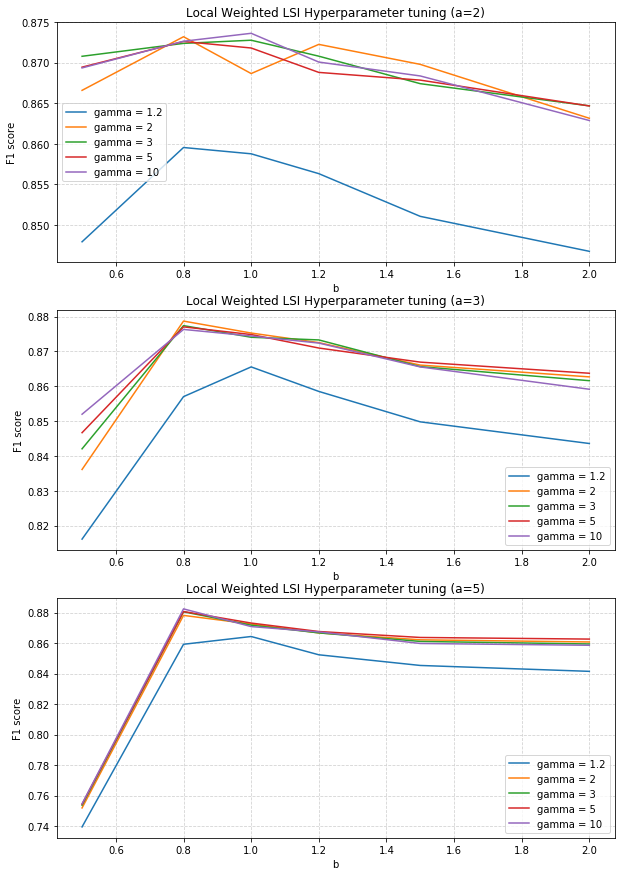

In [228]:
fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(10,15))

for i, ax in enumerate(axes.flat):
    for gamma_in in range(len(gamma_params)):
        ax.plot(b_params[1:], RES[gamma_in][i][1:],
                 label ='gamma = {}'.format(gamma_params[gamma_in]))
    ax.grid(color='lightgray', linestyle='dashed')
    ax.set_title('Local Weighted LSI Hyperparameter tuning (a={})'.format(a_params[i]))
    ax.set_xlabel('b')
    ax.set_ylabel('F1 score')
    ax.legend()
plt.savefig("Reuters_Weighted_hyperparameters.eps", bbox_inches='tight')
plt.show()

a = 5
b = 0.8
gamma = 5

Подбор С в Real_clf

In [229]:
components_list = [10,50, 100,300,500]
c_params = [0.01, 0.1, 1, 10, 100]

In [230]:
def res_append_C(X_train, y_train,X_test, y_test,component_list,initial_clf, c, a,b,gamma_size):
    results = {}
    for n_comp in component_list:
        real_clf = LinearSVC(C = c)
        t0 = time.time()
        pred = fit_predict(X_train, y_train,X_test,n_comp,initial_clf, real_clf, a,b,gamma_size)
        print (c, n_comp, '---->F1 score=',metrics.f1_score(y_test, pred, average='weighted'), \
                   'time passed: ', time.time() - t0,'\n')
        results[n_comp] = pred
    return results

In [231]:
results_c = Parallel(n_jobs=5)(delayed(res_append_C)(x_train, y_train,x_validate, y_validate,
                                      components_list,initial_clf,c,a =5, b=0.8,gamma_size = 5)
                               for c in c_params)

0.01 10 ---->F1 score= 0.362327862509 time passed:  63.18368434906006 

1 10 ---->F1 score= 0.815128741008 time passed:  65.0158679485321 

10 10 ---->F1 score= 0.785445513214 time passed:  66.27288746833801 

0.1 10 ---->F1 score= 0.719721327224 time passed:  66.87806677818298 

100 10 ---->F1 score= 0.765889425328 time passed:  67.38819169998169 

0.01 50 ---->F1 score= 0.370583513938 time passed:  87.29679703712463 

1 50 ---->F1 score= 0.869488678692 time passed:  88.54406380653381 

0.1 50 ---->F1 score= 0.757616084473 time passed:  87.38766765594482 

10 50 ---->F1 score= 0.814740017804 time passed:  91.24311184883118 

100 50 ---->F1 score= 0.76861840716 time passed:  91.86082458496094 

0.01 100 ---->F1 score= 0.371664294973 time passed:  165.04089617729187 

1 100 ---->F1 score= 0.880732789872 time passed:  169.7106523513794 

0.1 100 ---->F1 score= 0.760711393934 time passed:  170.87817215919495 

10 100 ---->F1 score= 0.837030412668 time passed:  179.4223997592926 

100 100 

In [232]:
RES_C = []
for n_comp in components_list:
    l =[]
    for n,c in enumerate(c_params):
        pred = results_c[n][n_comp]
        res = metrics.f1_score(y_validate, pred, average='weighted')
        l.append(res)
    RES_C.append(l)      

In [233]:
RES_C

[[0.362327862508738,
  0.7197213272235341,
  0.81512874100817756,
  0.78544551321418032,
  0.76588942532802096],
 [0.37058351393796551,
  0.75761608447320328,
  0.86948867869150714,
  0.81474001780396188,
  0.76861840715965202],
 [0.37166429497267528,
  0.76071139393389797,
  0.88073278987177173,
  0.83703041266782041,
  0.80003154614493299],
 [0.3728896680570441,
  0.76475562893802174,
  0.88739810588813361,
  0.86460584423988174,
  0.82568286612674902],
 [0.3728896680570441,
  0.76588917386641109,
  0.88730737356616662,
  0.86648959053040908,
  0.83053189267172711]]

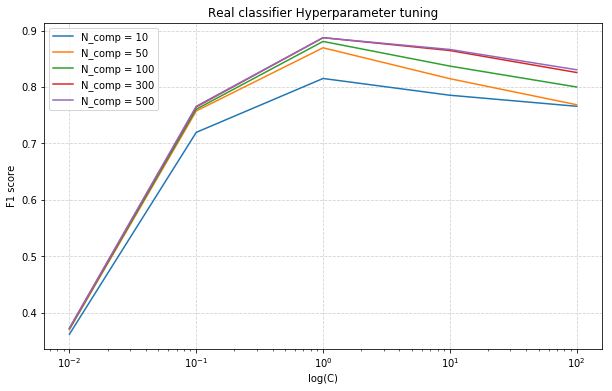

In [243]:
plt.figure(figsize=(10,6))
for n,n_comp in enumerate(components_list):
    plt.semilogx(c_params, RES_C[n],label ='N_comp = {}'.format(n_comp))
        
plt.grid(color='lightgray', linestyle='dashed')
plt.title('Real classifier Hyperparameter tuning')
plt.legend()
plt.xlabel('log(C)')
plt.ylabel('F1 score')
plt.savefig("Reuters_Local_grid_search_C.eps", bbox_inches='tight')
plt.show()

#### Local Weighted for full dataset

In [249]:
initial_clf = LinearSVC(C=0.1, random_state = 42)
c = 1
real_clf = LinearSVC(C=c, random_state = 42)
a = 5
b = 0.8
gamma = 5
components_list_final = [3, 8, 13, 20, 50, 100, 200, 300, 500, 700, 1000]

In [250]:
def Compute_Local_Weighted_full(n_comp):
    t0 = time.time()
    pred = fit_predict(vectors, labels_train, vectors_test,n_comp,initial_clf,real_clf,a,b,gamma)
    print (n_comp, 'time passed: ', time.time() - t0,'\n')
    return pred

In [251]:
results_Weighted_full = Parallel(n_jobs=4)(delayed(Compute_Local_Weighted_full)(n_comp)
                                           for n_comp in components_list_final)

3 time passed:  146.99103116989136 

8 time passed:  149.6489508152008 

13 time passed:  149.8495364189148 

20 time passed:  150.62915325164795 

50 time passed:  125.219078540802 

100 time passed:  135.7664749622345 

200 time passed:  163.25348496437073 

300 time passed:  195.90327429771423 

500 time passed:  271.16639518737793 

700 time passed:  322.64059710502625 

1000 time passed:  363.913845539093 



In [253]:
RESULTS_FINAL_WEIGHTED =[]
f1_scores =[]
precisions = []
recalls =[]
accuracies = []
for n in range(len(components_list_final)):
    pred = results_Weighted_full[n]
    f1_scores.append(metrics.f1_score(labels_test, pred, average='weighted'))
    precisions.append(metrics.precision_score(labels_test, pred, average='weighted'))
    recalls.append(metrics.recall_score(labels_test, pred, average='weighted'))
    accuracies.append(metrics.accuracy_score(labels_test, pred))
RESULTS_FINAL_WEIGHTED.append(f1_scores)
RESULTS_FINAL_WEIGHTED.append(precisions)
RESULTS_FINAL_WEIGHTED.append(recalls)
RESULTS_FINAL_WEIGHTED.append(accuracies)

### Comparison

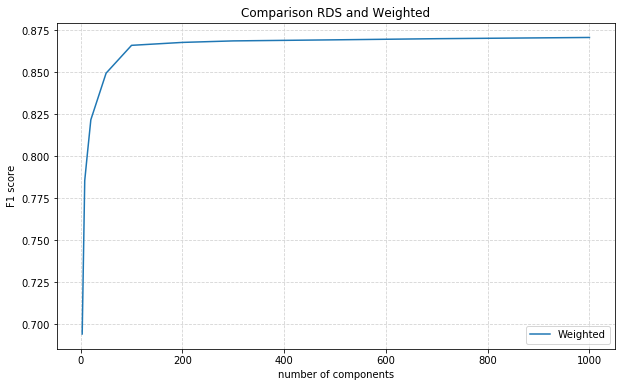

In [254]:
# F1 score
RESULTS_FINAL_RDS = np.load("Reuters_saved_RDS.npy")

plt.figure(figsize=(10,6))
#plt.plot(components_list_final, RESULTS_FINAL_RDS[0],label ='RDS')
plt.plot(components_list_final, RESULTS_FINAL_WEIGHTED[0],label ='Weighted')        
plt.grid(color='lightgray', linestyle='dashed')
plt.title('Comparison RDS and Weighted')
plt.legend()
plt.xlabel('number of components')
plt.ylabel('F1 score')
plt.savefig("F1_RDS_Weighted.eps", bbox_inches='tight')
plt.show()

#### Saving

In [255]:
file_Weighted = "Reuters_saved_Weighted.npy"
file_scores_Weighted = "Reuters_saved_scores_Weighted.npy"
np.save(file_Weighted, np.array(results_Weighted_full))
np.save(file_scores_Weighted, np.array(RESULTS_FINAL_WEIGHTED))